# Udacity Self-Driving Nanodegree
## Advanced Lane Lines

### Lane Detection Pipeline
1. Camera Calibration
2. Distortion Correction
3. Color Gradient Threshold
4. Perspective Transform

### Dependencies

In [1]:
import glob
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Camera Calibration

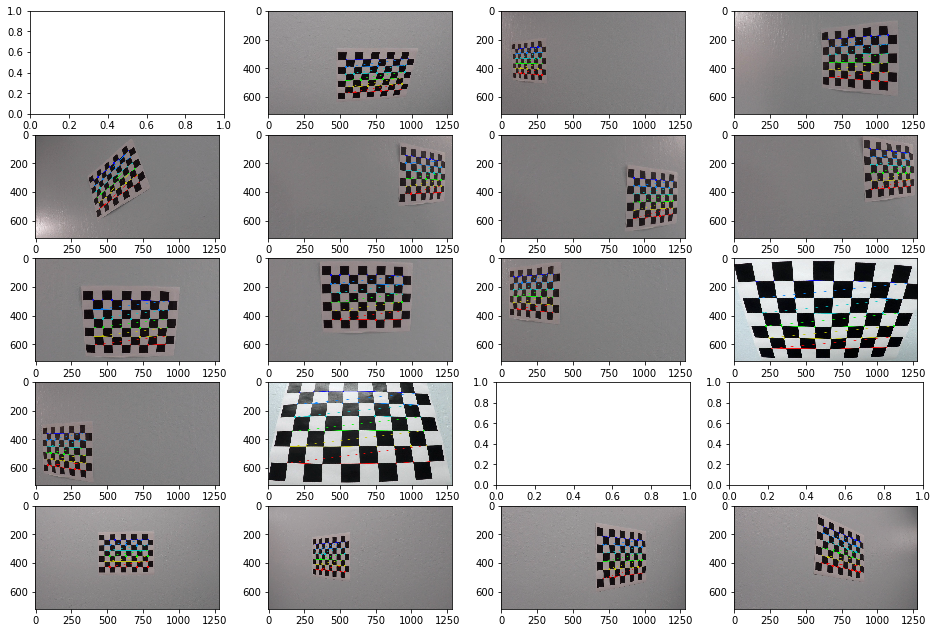

In [2]:
objgrid = np.zeros((9*6, 3), np.float32)
objgrid[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpts = [] # 3D points in real-world space
imgpts = [] # 2D points in image plane

images = glob.glob('camera_cal/calibration*.jpg')

grid, axes = plt.subplots(5, 4, figsize=(16, 11))
axes = axes.ravel()

for idx, filename in enumerate(images):    
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if ret == True:       
        objpts.append(objgrid)
        imgpts.append(corners)
        
        detected = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        # a blank panel means that corners were unable to be detected
        axes[idx].imshow(detected)

### Undistortion


True

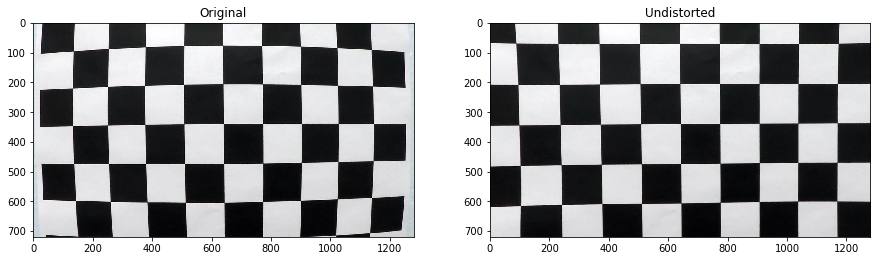

In [3]:
test_img = cv2.imread('camera_cal/calibration1.jpg')

img_size = (test_img.shape[1], test_img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
undist = cv2.undistort(test_img, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('dist_pickle.p', 'wb'))

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))
axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Undistorted')
axis2.imshow(undist)

cv2.imwrite('examples/undistort_output.png', undist)

### Image Thresholding

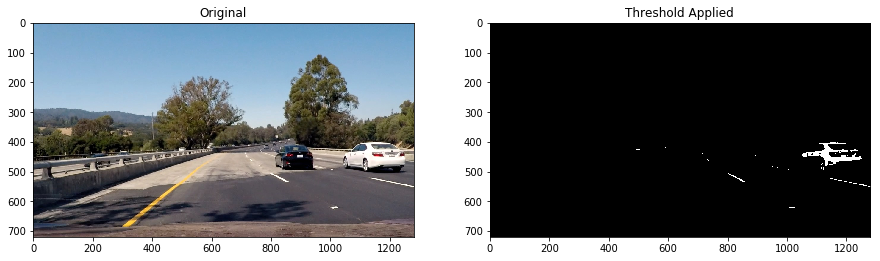

In [1000]:
def read_img(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def threshold_and_show(img, thresh_fn):
    grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))
    axis1.set_title('Original')
    axis1.imshow(img)
    axis2.set_title('Threshold Applied')   
    binary = thresh_fn(img)
    axis2.imshow(binary, cmap='gray')

def hls_lthreshold(img, thresh=(240, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]    
    binary = np.zeros_like(l_channel)
    binary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary

threshold_and_show(read_img('test_images/test4.jpg'), hls_lthreshold)

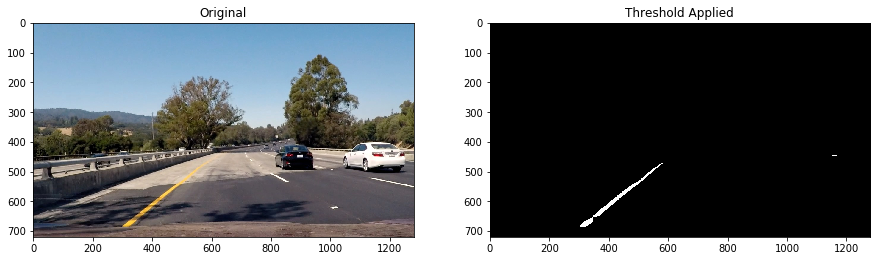

In [984]:
def lab_bthreshold(img, thresh=(200, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:, :, 2]
    normalized = b_channel * (255 / np.max(b_channel))
    binary = np.zeros_like(normalized)
    binary[((normalized >= thresh[0]) & (normalized <= thresh[1]))] = 1
    return binary

threshold_and_show(read_img('test_images/test4.jpg'), lab_bthreshold)

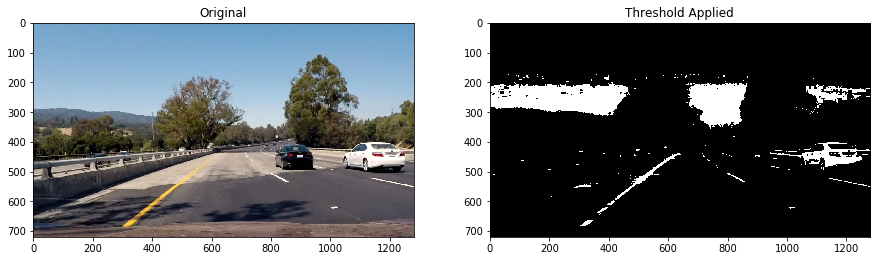

In [986]:
def hsv_vthreshold(img, thresh=(220, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:, :, 2]
    binary = np.zeros_like(v_channel)
    binary[((v_channel >= thresh[0]) & (v_channel <= thresh[1]))] = 1
    return binary

threshold_and_show(read_img('test_images/test4.jpg'), hsv_vthreshold)

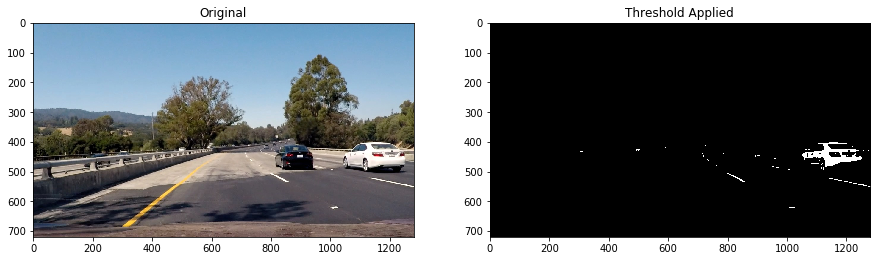

In [990]:
def luv_lthreshold(img, thresh=(230, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    l_channel = luv[:, :, 0]
    binary = np.zeros_like(l_channel)
    binary[((l_channel >= thresh[0]) & (l_channel <= thresh[1]))] = 1
    return binary

threshold_and_show(read_img('test_images/test4.jpg'), luv_lthreshold)

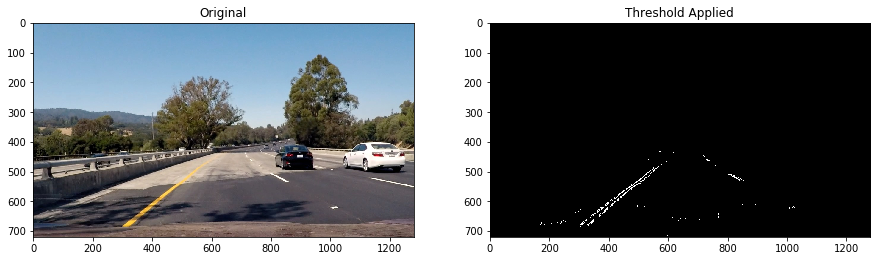

In [991]:
def region_mask(channel):    
    height, width = channel.shape[0], channel.shape[1]
    mask_top = int(height * 0.6)
    left,right = int(0.44 * width), int(0.54 * width)
    vertices = np.array([[(0, height), (left, mask_top), (right, mask_top), (width, height)]])
    
    mask = np.zeros_like(channel).astype(np.uint8)   
    cv2.fillPoly(mask, vertices, 1)
    masked_image = cv2.bitwise_and(channel, mask)
    return masked_image

def gradient_threshold(img, thresh=(30, 100)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = np.float64(img[:, :, 2])
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=3)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint(255 * abs_sobelx / np.max(abs_sobelx))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return region_mask(binary.astype(np.uint8))

threshold_and_show(read_img('test_images/test4.jpg'), gradient_threshold)

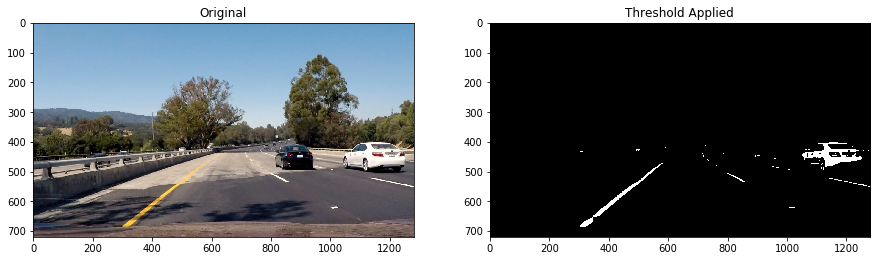

In [1029]:
def apply_threshold(img):
    l_binary = hls_lthreshold(img)
    b_binary = lab_bthreshold(img)
    luv_binary = luv_lthreshold(img)
    combined = np.zeros_like(l_binary)
    combined[(l_binary == 1) | (b_binary == 1) | (luv_binary == 1)] = 1
    return combined

threshold_and_show(read_img('test_images/test4.jpg'), apply_threshold)


### Perspective Transform

True

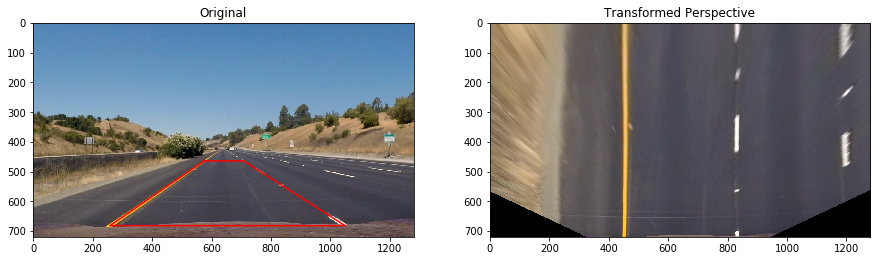

In [993]:
src = [(575, 464), (707, 464), (258, 682), (1049, 682)]
def top_perspective(img):
    height, width = img.shape[0], img.shape[1]
    dst = [(450, 0), (width - 450, 0), (450, height), (width - 450, height)]
    
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    
    warped = cv2.warpPerspective(img, M, (width, height))
    return warped, Minv

test_img = read_img('test_images/straight_lines1.jpg')
transformed, Minv = top_perspective(test_img)

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))

x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]

axis1.plot(x, y, color='#ff0000')
axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Transformed Perspective')
axis2.imshow(transformed)

cv2.imwrite('./examples/warped_straight_lines.jpg', transformed)

### Putting Everything Together

True

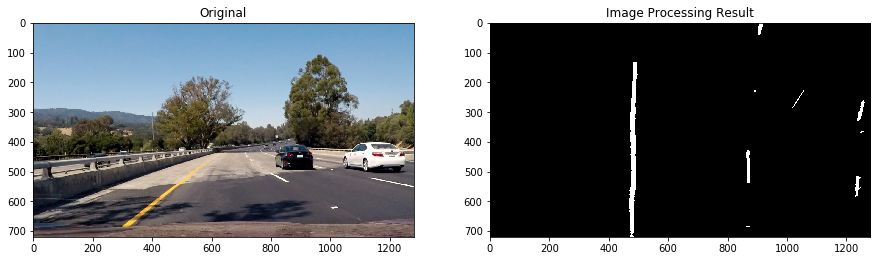

In [1035]:
def pipeline(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    perspective, minV = top_perspective(undist)   
    return apply_threshold(perspective), minV

test_img = read_img('test_images/test4.jpg')
result, _ = pipeline(test_img)

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))

axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Image Processing Result')
axis2.imshow(result, cmap='gray')
cv2.imwrite('./examples/pipeline.jpg', result * 255)

### Applying the Pipeline to All Images

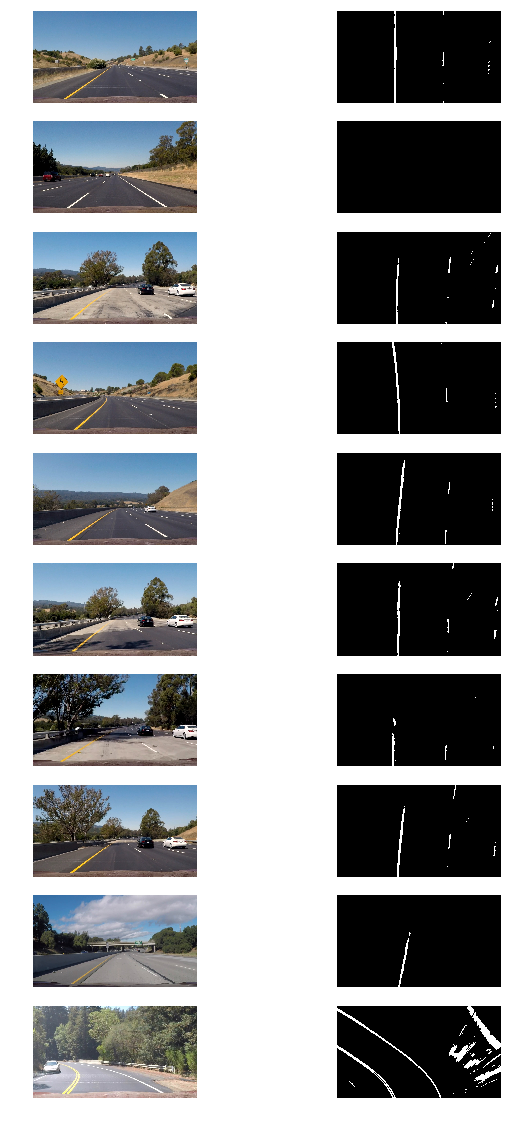

In [1036]:
img_files = glob.glob('./test_images/*.jpg')

grid, axes = plt.subplots(len(img_files), 2, figsize=(10, 20))
axes = axes.ravel()

idx = 0
for f in img_files:
    img = read_img(f)
    
    axes[idx].axis('off')
    axes[idx].imshow(img)
    idx += 1
    
    result, _ = pipeline(img)
    axes[idx].axis('off')
    axes[idx].imshow(result * 255, cmap='gray')
    idx += 1

### Finding the Lane Lines

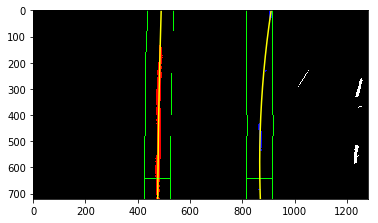

In [1021]:
# Sliding widnow algorithm to determine the initial lane curvature
def sliding_window_fit(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    
    midpoint = np.int((histogram.shape[0]/2))
    quarterpt = np.int(midpoint//2)
    # we reduce the starting search space to avoid artifacts
    # located on the sides of the image
    leftx_base = np.argmax(histogram[quarterpt:midpoint]) + quarterpt
    
    right_edge = histogram.shape[0] - quarterpt
    rightx_base = np.argmax(histogram[midpoint:right_edge]) + midpoint

    nwindows = 9 # number of sliding windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 50
    minpix = 50

    left_lane_idxs = []
    right_lane_idxs = []

    window_locations = []
    for window in range(nwindows):
        # window boundaries in x and y
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # store windows for visualization later
        window_locations.append(((win_xleft_low, win_y_low), (win_xleft_high, win_y_high)))
        window_locations.append(((win_xright_low, win_y_low), (win_xright_high, win_y_high)))
                                    
        # identify non-zero indices within the window
        good_left_idxs = ((nonzeroy >= win_y_low) 
                          & (nonzeroy < win_y_high) 
                          & (nonzerox >= win_xleft_low) 
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_idxs = ((nonzeroy >= win_y_low) 
                           & (nonzeroy < win_y_high) 
                           & (nonzerox >= win_xright_low) 
                           & (nonzerox < win_xright_high)).nonzero()[0]
    
        left_lane_idxs.append(good_left_idxs)
        right_lane_idxs.append(good_right_idxs)
       
        if len(good_left_idxs) > minpix:           
            leftx_current = np.int(np.mean(nonzerox[good_left_idxs]))
        if len(good_right_idxs) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_idxs]))        
            
    left_lane_idxs = np.concatenate(left_lane_idxs)
    right_lane_idxs = np.concatenate(right_lane_idxs)
    
    # Extract left and right line pixel locations
    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs]
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs]
    
    # Fit a second order polynomial, but we avoid creating a fit if no pixels were found
    left_fit = np.polyfit(lefty, leftx, 2) if len(left_lane_idxs) > 0 else None
    right_fit = np.polyfit(righty, rightx, 2) if len(right_lane_idxs) > 0 else None
    return out, left_fit, right_fit, left_lane_idxs, right_lane_idxs, window_locations

def visualize_fit(binary_warped, out, left_fitx, right_fitx, left_lane_idxs, right_lane_idxs, windows):
    # Visualize lane curves through polynomial fitting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
                                
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out[nonzeroy[left_lane_idxs], nonzerox[left_lane_idxs]] = [255, 0, 0]
    out[nonzeroy[right_lane_idxs], nonzerox[right_lane_idxs]] = [0, 0, 255]
    
    for window in windows:
        cv2.rectangle(out, window[0], window[1], (0, 255, 0), 2)
        
    plt.imshow(out)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('./examples/curve_fit.jpg')


test_img = read_img('./test_images/test4.jpg')
binary_warped, _ = pipeline(test_img)
result, left_fit, right_fit, left_lane_idxs, right_lane_idxs, windows = sliding_window_fit(binary_warped)

visualize_fit(binary_warped, result, left_fit, right_fit, left_lane_idxs, right_lane_idxs, windows)

### Curve Fitting for Subsequent Images

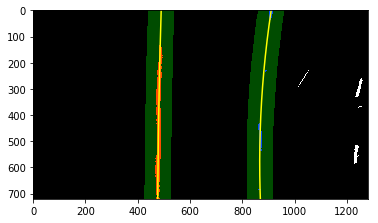

In [1022]:
# We don't need to do a full image scan. We'll just use the previous
# fits and adjust it for the new image
def next_fit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 50
    left_lane_idxs = ((nonzerox > (left_fit[0] * (nonzeroy**2)) + left_fit[1] * nonzeroy + left_fit[2] - margin)) \
                        & (nonzerox < (left_fit[0] * (nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))

    right_lane_idxs = ((nonzerox > (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) \
                        & (nonzerox < (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs]
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs]
    
    left_fit = np.polyfit(lefty, leftx, 2) if len(left_lane_idxs) > 0 else None
    right_fit = np.polyfit(righty, rightx, 2) if len(right_lane_idxs) > 0 else None
    
    return left_fit, right_fit, left_lane_idxs, right_lane_idxs

def visualize_next_fit(binary_warped, left_fit, right_fit, left_lane_idxs, right_lane_idxs):
    out = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out)
    
    margin = 50
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out[nonzeroy[left_lane_idxs], nonzerox[left_lane_idxs]] = [255, 0, 0]
    out[nonzeroy[right_lane_idxs], nonzerox[right_lane_idxs]] = [0, 0, 255]
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_w1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_w2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])                             
    left_line_pts = np.hstack((left_line_w1, left_line_w2))
                                 
    right_line_w1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_w2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])                        
    right_line_pts = np.hstack((right_line_w1, right_line_w2))    
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    
    result = cv2.addWeighted(out, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
# We reuse the previous test image since we don't have a set of consecutive lane images
left_fit, right_fit, left_lane_idxs, right_lane_idxs = next_fit(binary_warped, left_fit, right_fit)
visualize_next_fit(binary_warped, left_fit, right_fit, left_lane_idxs, right_lane_idxs)

### Calculating Curve Radius and Center Positioning

In [1003]:
ym_per_pix = 3/100 # meters per pixel in y
xm_per_pix = 3.7/376 # meters per pixel in x

def curve_radius(binary_warped, lane_idxs):    
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    x = nonzerox[lane_idxs]
    y = nonzeroy[lane_idxs]
       
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    y_eval = np.max(ploty)    
    
    # Fit new polynomials to x, y in world space
    fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)    
    curverad = ((1 + (2 * fit_cr[0] * y_eval * ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2 * fit_cr[0])   
    return curverad

def center_position(binary_warped, left_fit, right_fit):
    car_position = binary_warped.shape[1] / 2
    
    y = binary_warped.shape[0] 
    left_fitx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fitx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
        
    lane_position = (left_fitx + right_fitx) / 2    
    return (car_position - lane_position) * xm_per_pix

left_curve = curve_radius(binary_warped, left_lane_idxs)
right_curve = curve_radius(binary_warped, right_lane_idxs)
print(left_curve, 'm', right_curve, 'm')

center = center_position(binary_warped, left_fit, right_fit)
print('Center position: ', center, 'm')

2698.88584543 m 354.512822671 m
Center position:  -0.322241336077 m


### Visualizing the Lane Area

In [1004]:
def visualize_lane(warped, undist, Minv, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)    
    return result

def data_overlay(img, curve, center):
    copy = np.copy(img)
    
    curve_data = 'curve_radius: {:04.3f} m'.format(curve)        
    
    direction = ''
    if center < 0:
        direction = 'left'
    elif center > 0:
        direction = 'right'
    center_data = '{:04.3f} m {} of center'.format(abs(center), direction)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(copy, curve_data, (40,70), font, 1.0, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(copy, center_data, (40,120), font, 1.0, (200,255,155), 2, cv2.LINE_AA)
    return copy

### Putting Everything Together (Part 2)

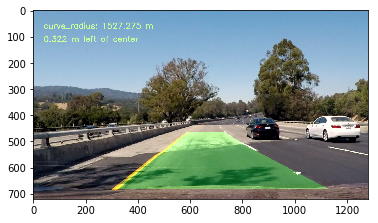

In [1005]:
test_img = read_img('./test_images/test4.jpg')

binary_warped, Minv = pipeline(test_img)
_, left_fit, right_fit, left_lane_idxs, right_lane_idxs, _ = sliding_window_fit(binary_warped)    
lane_img = visualize_lane(binary_warped, test_img, Minv, left_fit, right_fit)
    
left_curve = curve_radius(binary_warped, left_lane_idxs)
right_curve = curve_radius(binary_warped, right_lane_idxs)
center = center_position(binary_warped, left_fit, right_fit)
final_result = data_overlay(lane_img, (left_curve + right_curve) / 2, center)

plt.imshow(final_result)
plt.savefig('./examples/final.jpg')

### Project Video

In [1037]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_fitted = deque(maxlen=5)      
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None 
        self.curve_radius = 0
        
    def update_fit(self, fit):
        if fit is None:
            self.detected = False
            if len(self.recent_fitted) == self.recent_fitted.maxlen:
                self.recent_fitted.popleft()
            return
        
        if len(self.recent_fitted) == 0:
            self.detected = True
            self.recent_fitted.append(fit)
            self.best_fit = fit
            return
        
        diffs = abs(fit - self.best_fit)
        if diffs[0] > 0.001 or diffs[1] > 1.0 or diffs[2] > 100:
            self.detected = False
            if len(self.recent_fitted) == self.recent_fitted.maxlen:
                self.recent_fitted.popleft()
            return
        
        self.detected = True
        self.recent_fitted.append(fit)
        self.best_fit = np.average(self.recent_fitted, axis=0)
        
    def update_curve(self, curve):
        if self.curve_radius != 0 and abs(self.curve_radius - curve) > 350:
            self.detected = False
            
        self.curve_radius = curve
        
def sanity_check(left_fit, right_fit, height):
    if left_fit is None or right_fit is None:
        return False
    
    left_bottom_x = left_fit[0] * height ** 2 + left_fit[1] * height + left_fit[2]
    right_bottom_x = right_fit[0] * height ** 2 + right_fit[1] * height + right_fit[2]
    
    left_center_x = left_fit[0] * (height/2) ** 2 + left_fit[1] * (height/2) + left_fit[2]
    right_center_x = right_fit[0] * (height/2) ** 2 + right_fit[1] * (height/2) + right_fit[2]
    
    bottom_diff = abs(left_bottom_x - right_bottom_x)
    center_diff = abs(left_center_x - right_center_x)
    top_diff = abs(left_fit[2] - right_fit[2])    
    # Ideally I'll have a better way to test for parallel curves, but this might be a good heuristic
    # given that our base x's during the sliding search start in the same location
    return abs(bottom_diff - center_diff) < 100 and abs(top_diff - center_diff) < 100
    
left_line = Line()
right_line = Line()
def process_image(img): 
    global left_line
    global right_line
    
    img = img.copy()
    
    binary_warped, Minv = pipeline(img)
    
    if not left_line.detected or not right_line.detected:    
        _, left_fit, right_fit, left_lane_idxs, right_lane_idxs, _ = sliding_window_fit(binary_warped)
    else:
        left_fit, right_fit, left_lane_idxs, right_lane_idxs = next_fit(binary_warped, left_line.best_fit, right_line.best_fit)
            
    if sanity_check(left_fit, right_fit, img.shape[0]):
        left_line.update_fit(left_fit)
        right_line.update_fit(right_fit)
    else:
        left_line.detected = False
        right_line.detected = False  
        
    lane_img = visualize_lane(binary_warped, img, Minv, left_line.best_fit, right_line.best_fit)
    
    if left_fit is not None:
        left_line.update_curve(curve_radius(binary_warped, left_lane_idxs))   

    if right_fit is not None:
        right_line.update_curve(curve_radius(binary_warped, right_lane_idxs))
    
    center = center_position(binary_warped, left_line.best_fit, right_line.best_fit) 
    return data_overlay(lane_img, (left_line.curve_radius + right_line.curve_radius) / 2, center)


In [1038]:
output_file = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 15%|█▍        | 188/1261 [00:19<01:48,  9.85it/s]


 30%|███       | 381/1261 [00:39<01:31,  9.67it/s]


 43%|████▎     | 537/1261 [00:56<01:15,  9.64it/s]


 55%|█████▍    | 691/1261 [01:13<00:59,  9.57it/s]


 68%|██████▊   | 859/1261 [01:30<00:41,  9.59it/s]


 81%|████████  | 1021/1261 [01:48<00:25,  9.45it/s]


 93%|█████████▎| 1172/1261 [02:04<00:09,  9.65it/s]


100%|█████████▉| 1260/1261 [02:14<00:00,  8.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 4min, sys: 22.1 s, total: 4min 22s
Wall time: 2min 15s


In [1039]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output_file))

### Challenge Video

In [1018]:
output_file = 'challenge_video_out.mp4'
clip = VideoFileClip('challenge_video.mp4')
left_line = Line()
right_line = Line()

out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

TypeError: set_detected() takes 1 positional argument but 2 were given

False False


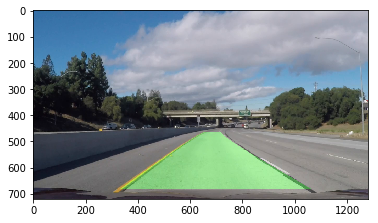

In [915]:
left_line = Line()
right_line = Line()
frame = clip.get_frame(0.0)

out, _ = top_perspective(frame)
out = equalize_histogram(out)
out = apply_threshold(out)
result, left_fit, right_fit, left_lane_idxs, right_lane_idxs, windows = sliding_window_fit(out)
plt.imshow(visualize_lane(out, frame, Minv, left_fit, right_fit))
#visualize_fit(out, result, left_fit, right_fit, left_lane_idxs, right_lane_idxs, windows)

print(left_line.detected, right_line.detected)

In [893]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output_file))

### Harder Challenge Video